In [4]:
import pandas as pd

# Load both datasets
trades = pd.read_csv("fear_greed_index - Copy.csv")
sentiment = pd.read_csv("historical_data - Copy.csv")

# Convert timestamps to real dates
trades["date"] = pd.to_datetime(trades["timestamp"], unit="s")
sentiment["date"] = pd.to_datetime(sentiment["Timestamp"], unit="ms")

# Convert to only date part (remove time)
trades["date"] = trades["date"].dt.date
sentiment["date"] = sentiment["date"].dt.date

# Convert to Year-Month period so you can compare month-wise
trades["year_month"] = pd.to_datetime(trades["date"]).dt.to_period("M")
sentiment["year_month"] = pd.to_datetime(sentiment["date"]).dt.to_period("M")

print(trades.head())
print(sentiment.head())


    timestamp  value classification        date year_month
0  1517463000     30           Fear  2018-02-01    2018-02
1  1517549400     15   Extreme Fear  2018-02-02    2018-02
2  1517635800     40           Fear  2018-02-03    2018-02
3  1517722200     24   Extreme Fear  2018-02-04    2018-02
4  1517808600     11   Extreme Fear  2018-02-05    2018-02
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.52

In [5]:
trades_monthly = trades.groupby("year_month")["value"].mean().reset_index()

sentiment_monthly = sentiment.groupby("year_month").agg({
    "Closed PnL": "sum",
    "Size USD": "sum"
}).reset_index()


final = trades_monthly.merge(sentiment_monthly, on="year_month", how="left")


print(final.head())
print(final.columns)


# Save final DataFrame to a CSV file
final.to_csv("final_data.csv", index=False)  # index=False avoids writing row numbers


  year_month      value  Closed PnL  Size USD
0    2018-02  42.642857         NaN       NaN
1    2018-03  35.193548         NaN       NaN
2    2018-04  29.814815         NaN       NaN
3    2018-05  40.096774         NaN       NaN
4    2018-06  26.166667         NaN       NaN
Index(['year_month', 'value', 'Closed PnL', 'Size USD'], dtype='object')


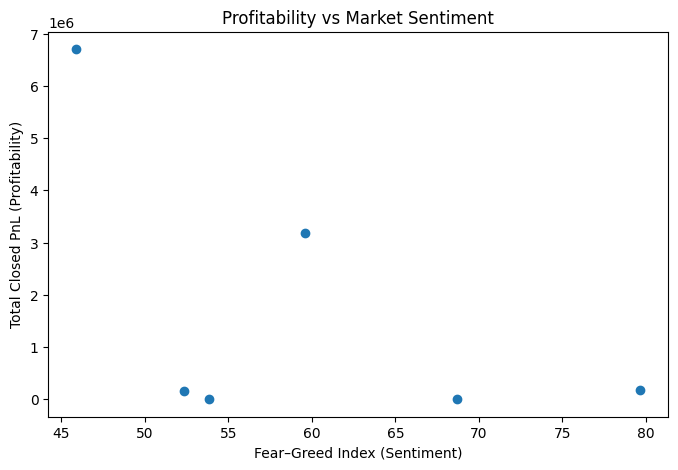

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.scatter(final["value"], final["Closed PnL"])

plt.xlabel("Fear–Greed Index (Sentiment)")
plt.ylabel("Total Closed PnL (Profitability)")
plt.title("Profitability vs Market Sentiment")

plt.show()


  sentiment_category    PnL_change
0              Greed  1.249136e+05
1            Neutral  1.913889e+06


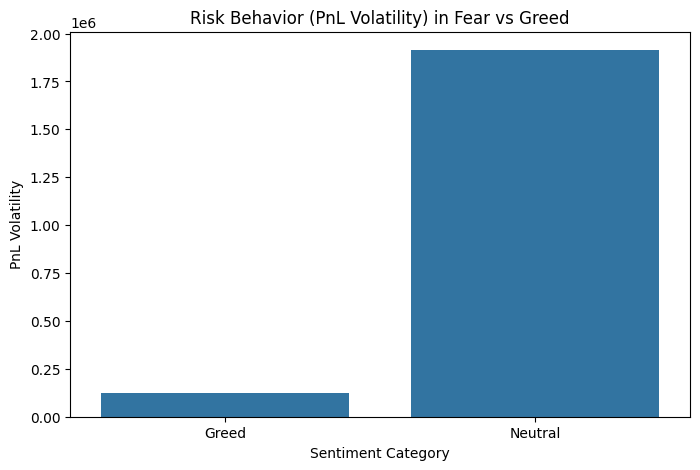

In [6]:
# Remove rows where Closed PnL is NaN because they represent no trading activity
import seaborn as sns
filtered = final.dropna(subset=["Closed PnL"]).copy()

# Calculate month-to-month PnL change
filtered["PnL_change"] = filtered["Closed PnL"].diff()

# Categorise sentiments again (if needed)
filtered["sentiment_category"] = filtered["value"].apply(
    lambda x: "Fear" if x < 40 else ("Greed" if x > 60 else "Neutral")
)

# Compute volatility (std deviation of PnL change) in each sentiment state
volatility = filtered.groupby("sentiment_category")["PnL_change"].std().reset_index()

print(volatility)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=volatility, x="sentiment_category", y="PnL_change")
plt.title("Risk Behavior (PnL Volatility) in Fear vs Greed")
plt.xlabel("Sentiment Category")
plt.ylabel("PnL Volatility")
plt.show()


In [8]:
def categorize_sentiment(x):
    if x < 40:
        return "Fear"
    elif x <= 60:
        return "Neutral"
    else:
        return "Greed"

final["sentiment_category"] = final["value"].apply(categorize_sentiment)


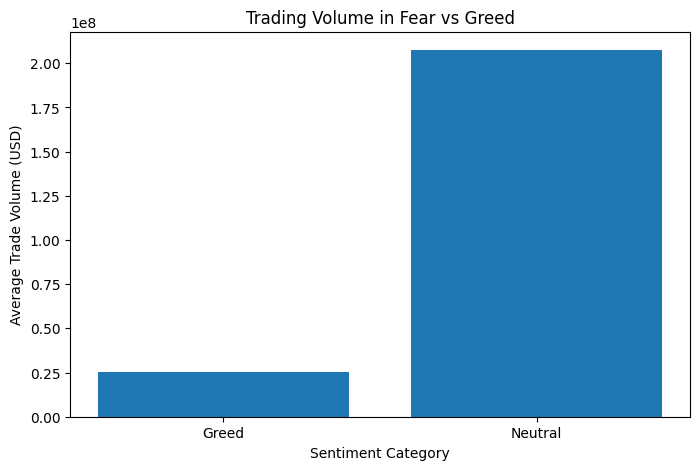

In [9]:
# Volume vs Sentiment

import matplotlib.pyplot as plt

volume_behavior = final.groupby("sentiment_category")["Size USD"].mean()

plt.figure(figsize=(8, 5))
plt.bar(volume_behavior.index, volume_behavior.values)

plt.xlabel("Sentiment Category")
plt.ylabel("Average Trade Volume (USD)")
plt.title("Trading Volume in Fear vs Greed")

plt.show()


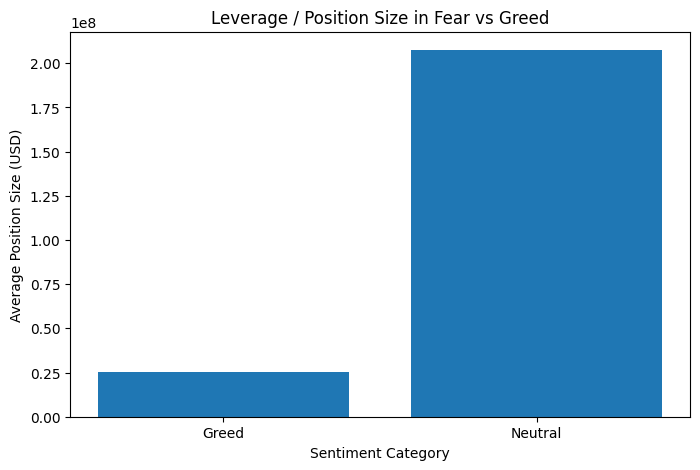

In [10]:
#leverage vs sentiment
import matplotlib.pyplot as plt

leverage_behavior = final.groupby("sentiment_category")["Size USD"].mean()

plt.figure(figsize=(8, 5))
plt.bar(leverage_behavior.index, leverage_behavior.values)

plt.xlabel("Sentiment Category")
plt.ylabel("Average Position Size (USD)")
plt.title("Leverage / Position Size in Fear vs Greed")

plt.show()
